[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/giulatona/iecon2025_tutorial/blob/main/notebooks/03_forecasting_models.ipynb)

# Deep Learning for Energy Forecasting - Model Training

This notebook demonstrates training various forecasting models on the household power consumption dataset, from simple baselines to advanced deep learning architectures. We focus on **multi-step, day-ahead forecasting of a univariate target (Global_active_power)** while leveraging rich **exogenous inputs**: both the original other variables in the dataset and engineered calendar/Fourier features produced during preprocessing.

## Learning Objectives
- Implement baseline forecasting models (naive seasonal)
- Build and train feedforward neural networks for time series
- Develop LSTM Encoder-Decoder architectures
- Compare model performance and understand trade-offs
- Apply proper evaluation metrics for time series forecasting

## 1. Setup and Data Loading

In [1]:
# Import preprocessing functions from shared utilities module

# Check if running in Google Colab
in_colab = 'google.colab' in str(get_ipython())

# Add the src directory to Python path for imports
if in_colab:
    # For Colab, install the package directly from GitHub
    print("Installing iecon2025_tutorial package from GitHub...")
    try:
        %pip install git+https://github.com/giulatona/iecon2025_tutorial.git
        from iecon2025_tutorial.preprocessing import load_and_preprocess_data
        print("✅ Successfully installed and imported preprocessing functions from GitHub")
    except Exception as e:
        print(f"❌ Installation error: {e}")
        print("Please check the GitHub repository URL and try again")
else:
    try:
        from iecon2025_tutorial.preprocessing import load_and_preprocess_data
        print("✅ Successfully imported preprocessing functions from local utilities module")
    except ImportError as e:
        print(f"❌ Import error: {e}")
        print("Please ensure the src/iecon2025_tutorial directory contains preprocessing.py")

✅ Successfully imported preprocessing functions from local utilities module


In [2]:
# Import essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
#import warnings
#warnings.filterwarnings('ignore')

# Deep learning frameworks
import tensorflow as tf
import keras

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

GPU available: []


### 1.1 Data Download if Needed

We'll use the same household power consumption dataset from the UCI Machine Learning Repository.

In [3]:
# Download data if not available locally
import os
import urllib.request
import zipfile

if in_colab:
    print("Running in Google Colab - downloading dataset...")
    !wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
    !unzip -q household_power_consumption.zip
    data_file = 'household_power_consumption.txt'
else:
    print("Running locally...")
    data_file = 'data/household_power_consumption.txt'
    
    # Create data directory if it doesn't exist
    os.makedirs('data', exist_ok=True)
    
    # Download dataset if it doesn't exist locally
    if not os.path.exists(data_file):
        print("Dataset not found locally. Downloading...")
        url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
        zip_file = 'data/household_power_consumption.zip'
        
        # Download the zip file
        urllib.request.urlretrieve(url, zip_file)
        print("Download completed. Extracting...")
        
        # Extract the zip file
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall('data/')
        
        print("Extraction completed.")
    else:
        print("Dataset found locally.")

print(f"Using data file: {data_file}")

Running locally...
Dataset found locally.
Using data file: data/household_power_consumption.txt


## 2. Data Loading and Basic Preprocessing

In [5]:
# Setup configuration for preprocessing and training
SETUP_CONFIG = {
    'window_size': 36,          # 36 hours of historical data
    'forecast_horizon': 24,     # Predict next 24 hours
    'batch_size': 32,
    'max_epochs': 50,
    'validation_split': 0.2,
    'initial_learning_rate': 0.01,
    'target_columns': [0],      # Index of target variable (Global_active_power)
    'use_time_features': True,
    'use_holiday_features': False,
    'downsample_freq': '1H',
    'num_fourier_terms': 3,
}

In [6]:
# Load and preprocess the dataset using the preprocessing pipeline
results = load_and_preprocess_data(
    data_path=str(data_file),
    downsample_freq=SETUP_CONFIG['downsample_freq'],
    num_fourier_terms=SETUP_CONFIG['num_fourier_terms'],
    window_size=SETUP_CONFIG['window_size'],
    forecast_horizon=SETUP_CONFIG['forecast_horizon'],
    batch_size=SETUP_CONFIG['batch_size'],
    target_columns=SETUP_CONFIG['target_columns'],  # Predict Global_active_power only
    use_time_features=SETUP_CONFIG['use_time_features'],
    use_holiday_features=SETUP_CONFIG['use_holiday_features'],
    verbose=True  # Enable function's verbose output
)

# Extract the datasets and metadata
train_dataset = results['datasets']['train']
val_dataset = results['datasets']['val']
test_dataset = results['datasets']['test']

scaler_params = results['scaler_params']
feature_names = results['feature_names']
preprocessing_info = results['preprocessing_info']

raw_train_df = results['raw_data']['train']
raw_val_df = results['raw_data']['val']
raw_test_df = results['raw_data']['test']

# Get data shapes for model building
for inputs, targets in train_dataset.take(1):
    input_shape = inputs.shape
    target_shape = targets.shape
    num_features = input_shape[-1]
    break

# Show final summary
print(f"Ready for training - Input: {input_shape}, Target: {target_shape}")
print(f"Features: {preprocessing_info['feature_count']}, Samples: {preprocessing_info['split_info']['train_samples']:,}")

Starting preprocessing pipeline...
✅ Data loaded and cleaned
✅ Data loaded and cleaned
✅ Missing values filled
✅ Missing values filled
✅ Time features added
✅ Time features added


/workspaces/iecon2025_tutorial/src/iecon2025_tutorial/preprocessing.py:86: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_downsampled = df.resample(freq).mean()


✅ Data downsampled
✅ Data split completed
✅ Features normalized
✅ Sliding windows created
✅ Preprocessing pipeline completed!
Ready for training - Input: (32, 36, 19), Target: (32, 24, 1)
Features: 19, Samples: 24,212
✅ Sliding windows created
✅ Preprocessing pipeline completed!
Ready for training - Input: (32, 36, 19), Target: (32, 24, 1)
Features: 19, Samples: 24,212


In [7]:
print("Feature names:")
for name in feature_names:
    print(f"  - {name}")

Feature names:
  - Global_active_power
  - Global_reactive_power
  - Voltage
  - Global_intensity
  - Sub_metering_1
  - Sub_metering_2
  - Sub_metering_3
  - Day sin1
  - Day cos1
  - Year sin1
  - Year cos1
  - Day sin2
  - Day cos2
  - Year sin2
  - Year cos2
  - Day sin3
  - Day cos3
  - Year sin3
  - Year cos3


## 3 Keras Model Building Basics
Before we dive into energy-specific architectures, it helps to recall how Keras assembles neural networks. All three APIs ultimately produce a `keras.Model`, but each favors a different workflow:
- **Sequential API** keeps things linear. You stack layers in order, perfect for quick prototypes or feedforward stacks where every layer has a single input and output.
- **Functional API** treats layers like functions. You can route tensors through multiple branches, merge them, or expose several inputs/outputs—ideal when the data pipeline becomes more complex.
- **Subclassing API** gives you full Python control. You inherit from `keras.Model`, define layers in `__init__`, and implement the `call` method to describe the forward pass. This is the most flexible approach for custom behaviors, sharing weights, or injecting non-standard logic.

Below we recreate the same simple forecaster with each API: flatten the input window, apply a dense hidden layer, and emit the multi-step forecast. Seeing them side by side clarifies how to pick the right abstraction for your project.

In [8]:
# Sequential API: layers execute in order
sequential_example = keras.models.Sequential([
    keras.layers.Input(shape=(SETUP_CONFIG['window_size'], num_features)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dense(SETUP_CONFIG['forecast_horizon'], name="forecast_head"),
    keras.layers.Reshape((SETUP_CONFIG['forecast_horizon'], 1)),
])
sequential_example.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 684)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        43,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ forecast_head (Dense)           │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 24, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,400 (177.34 KB)

 Trainable params: 45,400 (177.34 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Functional API: define explicit data flow between layers
func_inputs = keras.layers.Input(shape=(SETUP_CONFIG['window_size'], num_features), name="window_inputs")
x = keras.layers.Flatten(name="flatten_window")(func_inputs)
x = keras.layers.Dense(64, activation="relu", name="hidden_dense")(x)
x = keras.layers.Dense(SETUP_CONFIG['forecast_horizon'], name="forecast_dense")(x)
func_outputs = keras.layers.Reshape((SETUP_CONFIG['forecast_horizon'], 1), name="reshape_output")(x)
functional_example = keras.Model(inputs=func_inputs, outputs=func_outputs, name="functional_baseline")
functional_example.summary()

Model: "functional_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ window_inputs (InputLayer)      │ (None, 36, 19)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_window (Flatten)        │ (None, 684)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_dense (Dense)            │ (None, 64)             │        43,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ forecast_dense (Dense)          │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_output (Reshape)        │ (None, 24, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,400 (177.34 KB)

 Trainable params: 45,400 (177.34 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Subclassing API: implement the forward pass manually
class SubclassForecaster(keras.Model):
    def __init__(self, hidden_units):
        super().__init__(name="subclass_forecaster")
        self.flatten = keras.layers.Flatten()
        self.hidden = keras.layers.Dense(hidden_units, activation="relu")
        self.projection = keras.layers.Dense(SETUP_CONFIG['forecast_horizon'])
        self.reshape = keras.layers.Reshape((SETUP_CONFIG['forecast_horizon'], 1))

    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.hidden(x)
        x = self.projection(x)
        return self.reshape(x)

subclass_example = SubclassForecaster(hidden_units=64)
# we need to trigger lazy weight creation because in subclassing API weights are created upon first call
_ = subclass_example(tf.zeros((1, SETUP_CONFIG['window_size'], num_features)))
subclass_example.summary()

Model: "subclass_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (1, 684)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 64)                │        43,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (1, 24)                │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (1, 24, 1)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,400 (177.34 KB)

 Trainable params: 45,400 (177.34 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Baseline Models
The naive seasonal baseline assumes the target series repeats after a fixed seasonal lag (e.g., the previous day or week). Given an input window of length `W`, a forecast horizon `H`, and a seasonal period `S`, the prediction simply copies the target feature from `S` steps earlier: $\hat{y}_{t+h} = y_{t+h-S}$ for $h = 1,...,H$. This strong yet parameter-free benchmark highlights how much value more complex models add.

We can express this logic compactly with the **Sequential API**. After declaring the `Input` layer we insert a `keras.layers.Lambda`, which lets us wrap an arbitrary Python callable that operates on the incoming tensor. In our case the lambda slices the last seasonal chunk of the target feature and returns it unchanged, effectively “copying” the values into the forecast horizon. Because the layer sits inside a proper Keras model, it plays nicely with `model.predict`, `model.evaluate`, and the rest of the tooling.

In [11]:
SEASONAL_PERIOD = 24  # Number of time steps representing one seasonal cycle
used_target_index = SETUP_CONFIG['target_columns'][0]

def build_naive_seasonal_model(window_size, forecast_horizon, num_features, seasonal_period, target_index=0):
    """Return a Sequential model that copies the target from the previous seasonal cycle."""
    if window_size < seasonal_period:
        raise ValueError("window_size must be >= seasonal_period for the naive seasonal baseline.")
    if forecast_horizon > seasonal_period:
        raise ValueError("forecast_horizon must be <= seasonal_period for the naive seasonal baseline.")

    start_idx = window_size - seasonal_period
    end_idx = start_idx + forecast_horizon

    model = keras.models.Sequential(name="naive_seasonal_model")
    model.add(keras.layers.Input(shape=(window_size, num_features)))
    model.add(keras.layers.Lambda(
        lambda x: x[:, start_idx:end_idx, target_index:target_index + 1],
        name="naive_seasonal_copy",
    ))
    return model

naive_seasonal_model = build_naive_seasonal_model(
    window_size=SETUP_CONFIG['window_size'],
    forecast_horizon=SETUP_CONFIG['forecast_horizon'],
    num_features=num_features,
    seasonal_period=SEASONAL_PERIOD,
    target_index=used_target_index,
 )

### 4.1 Example Forecast Sanity Check

In [12]:
# we make a batch with a single example
# the example has zeros everywhere except for the last seasonal_period time steps of the target feature
# which are filled with a simple increasing sequence 1, 2, ..., seasonal_period
# we expect the model to copy the last seasonal_period values into the forecast horizon
example_input = np.zeros((1, SETUP_CONFIG['window_size'], num_features), dtype=np.float32)
example_input[:, -SEASONAL_PERIOD:, used_target_index] = np.arange(1, SEASONAL_PERIOD + 1, dtype=np.float32)


# to run the model we call it (like a function) on the example input
example_output = naive_seasonal_model(example_input)


print("Example output shape:", example_output.shape)


print("Input target feature values:", example_input[0, :, used_target_index])
print("Output target feature values:", example_output.numpy()[0, :, 0])

Example output shape: (1, 24, 1)
Input target feature values: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  3.  4.  5.  6.
  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24.]
Output target feature values: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24.]


In [13]:
naive_seasonal_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.0),
    loss=keras.losses.MeanSquaredError(),
    metrics=[
        keras.metrics.MeanAbsoluteError(name="mae"),
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

In [14]:
def plot_forecast_sample(model, dataset, config, sample_index=0, target_index=0, title=None):
    """Plot history, ground truth, and model forecast for one sample from the first batch."""
    inputs, targets = next(iter(dataset))
    inputs_np = inputs.numpy()
    targets_np = targets.numpy()
    preds_np = model.predict(inputs, verbose=0)

    batch_size = inputs_np.shape[0]
    if sample_index >= batch_size:
        raise ValueError(f"sample_index {sample_index} out of range for batch size {batch_size}.")

    window_size = config['window_size']
    forecast_horizon = config['forecast_horizon']

    history_steps = range(window_size)
    forecast_steps = range(window_size, window_size + forecast_horizon)

    plt.figure(figsize=(10, 4))
    plt.plot(history_steps, inputs_np[sample_index, :, target_index], label="History")
    plt.plot(forecast_steps, targets_np[sample_index, :, target_index], label="Ground Truth", marker="o")
    plt.plot(forecast_steps, preds_np[sample_index, :, target_index], label="Forecast", marker="o")
    plt.xlabel("Time step")
    plt.ylabel("Global_active_power (scaled)")
    if title is None:
        title = f"Forecast comparison (sample {sample_index})"
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

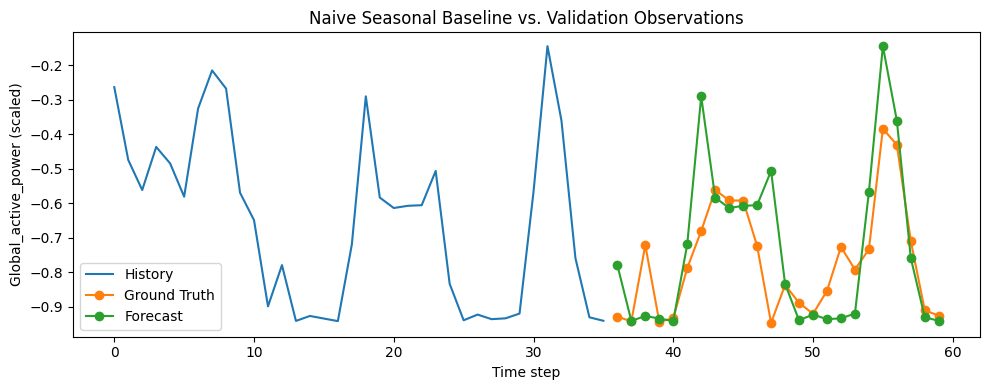

In [15]:
plot_forecast_sample(
    model=naive_seasonal_model,
    dataset=val_dataset,
    config=SETUP_CONFIG,
    sample_index=0,
    target_index=used_target_index,
    title="Naive Seasonal Baseline vs. Validation Observations"
)

### 4.1 Example Forecast Sanity Check

Let's see how to make a prediction with the model.

In [16]:
split_datasets = {
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset
}
baseline_metrics = {}
for split_name, dataset in split_datasets.items():
    baseline_metrics[split_name] = naive_seasonal_model.evaluate(dataset, verbose=0, return_dict=True)

In [17]:
for split_name, values in baseline_metrics.items():
    print(f"{split_name} metrics:")
    for metric_name, value in values.items():
        print(f"  {metric_name}: {value:.4f}")

train metrics:
  loss: 0.0941
  mae: 0.2055
  rmse: 0.3067
val metrics:
  loss: 0.0864
  mae: 0.2039
  rmse: 0.2940
test metrics:
  loss: 0.0533
  mae: 0.1549
  rmse: 0.2309


### 4.2 Evaluate on Each Dataset Split

`model.evaluate` runs a forward pass and computes the configured loss/metrics. We loop through the train/validation/test datasets produced by the preprocessing step to understand how the baseline performs across all splits.

In [18]:
DENSE_LAYER_UNITS = [128, 64]

def build_feedforward_forecaster(window_size, num_features, forecast_horizon, dense_units, target_dim=1):
    """Create a feedforward network for multi-step forecasting."""
    inputs = keras.layers.Input(shape=(window_size, num_features), name="ffnn_inputs")
    #x = keras.layers.Flatten(name="flatten_window")(inputs)
    x = keras.layers.Reshape(name="reshape_flat", target_shape=(window_size * num_features,))(inputs)
    for i, units in enumerate(dense_units):
        x = keras.layers.Dense(units, activation="relu", name=f"dense_{i+1}")(x)
    x = keras.layers.Dense(forecast_horizon * target_dim, name="forecast_head")(x)
    outputs = keras.layers.Reshape(target_shape=(forecast_horizon, target_dim), name="reshape_output")(x)
    return keras.Model(inputs=inputs, outputs=outputs, name="feedforward_forecaster")

feedforward_model = build_feedforward_forecaster(
    window_size=SETUP_CONFIG['window_size'],
    num_features=num_features,
    forecast_horizon=SETUP_CONFIG['forecast_horizon'],
    dense_units=DENSE_LAYER_UNITS
)

feedforward_model.summary()

Model: "feedforward_forecaster"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ffnn_inputs (InputLayer)        │ (None, 36, 19)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_flat (Reshape)          │ (None, 684)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        87,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ forecast_head (Dense)           │ (None, 24)             │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_output (Reshape)        │ (None, 24, 1)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,496 (380.84 KB)

 Trainable params: 97,496 (380.84 KB)

 Non-trainable params: 0 (0.00 B)

None in the output shape refers to the batch size. It just means that it is unspecified, so the model can be called with different batch sizes

In [19]:
feedforward_model(example_input)

<tf.Tensor: shape=(1, 24, 1), dtype=float32, numpy=
array([[[-0.30964732],
        [-2.108588  ],
        [ 3.3660975 ],
        [-1.1533632 ],
        [-1.813753  ],
        [ 2.2649672 ],
        [-2.3245497 ],
        [-0.30018008],
        [-0.05417011],
        [ 0.09579367],
        [-1.5662004 ],
        [-0.70050365],
        [-1.7556748 ],
        [ 3.1681232 ],
        [-0.32879964],
        [-1.7544034 ],
        [ 0.01701552],
        [-1.1517787 ],
        [-3.3639684 ],
        [ 2.2771115 ],
        [-1.6813    ],
        [-1.3328708 ],
        [ 1.1659606 ],
        [-3.9194028 ]]], dtype=float32)>

In [20]:
feedforward_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=SETUP_CONFIG['initial_learning_rate']),
    loss=keras.losses.MeanSquaredError(),
    metrics=[
        keras.metrics.MeanAbsoluteError(name="mae"),
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

As reference for later, lets evaluate the untrained model (with weights initialized at random) and look at the metrics

In [21]:
untrained_ff_metrics = {}
for split_name, dataset in split_datasets.items():
    untrained_ff_metrics[split_name] = feedforward_model.evaluate(dataset, verbose=0, return_dict=True)

for split_name, values in untrained_ff_metrics.items():
    print(f"{split_name} metrics:")
    for metric_name, value in values.items():
        print(f"  {metric_name}: {value:.4f}")

train metrics:
  loss: 0.9470
  mae: 0.8272
  rmse: 0.9731
val metrics:
  loss: 0.9010
  mae: 0.7990
  rmse: 0.9492
test metrics:
  loss: 0.9433
  mae: 0.8353
  rmse: 0.9712


In [22]:
history = feedforward_model.fit(train_dataset, validation_data=val_dataset, epochs=SETUP_CONFIG['max_epochs'], verbose=1)

Epoch 1/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1953 - mae: 0.3283 - rmse: 0.4271 - val_loss: 0.0715 - val_mae: 0.2113 - val_rmse: 0.2673
Epoch 2/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1953 - mae: 0.3283 - rmse: 0.4271 - val_loss: 0.0715 - val_mae: 0.2113 - val_rmse: 0.2673
Epoch 2/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0720 - mae: 0.2045 - rmse: 0.2683 - val_loss: 0.0635 - val_mae: 0.1977 - val_rmse: 0.2521
Epoch 3/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0720 - mae: 0.2045 - rmse: 0.2683 - val_loss: 0.0635 - val_mae: 0.1977 - val_rmse: 0.2521
Epoch 3/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0663 - mae: 0.1950 - rmse: 0.2575 - val_loss: 0.0597 - val_mae: 0.1904 - val_rmse: 0.2443
Epoch 4/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0663 - mae: 0.1950 - rmse: 0.2575 - val_loss: 0.0597 - val_mae: 0.1904 - val_rmse: 0.2443
Epoch 4/50
755/755 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0634 - mae: 0.1898 - rmse:

### 5.1 Training Curves

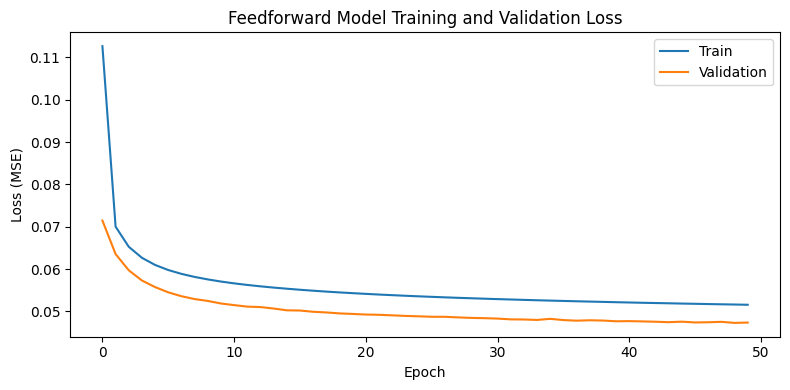

In [23]:
if history is None:
    raise ValueError("Run the training cell to populate `history` before plotting.")

history_df = pd.DataFrame(history.history)
ax = history_df[["loss", "val_loss"]].plot(figsize=(8, 4))
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (MSE)")
ax.set_title("Feedforward Model Training and Validation Loss")
ax.legend(["Train", "Validation"])
plt.tight_layout()
plt.show()

In [24]:
ff_metrics = {}
for split_name, dataset in split_datasets.items():
    ff_metrics[split_name] = feedforward_model.evaluate(dataset, verbose=0, return_dict=True)

for split_name, values in ff_metrics.items():
    print(f"{split_name} metrics:")
    for metric_name, value in values.items():
        print(f"  {metric_name}: {value:.4f}")


train metrics:
  loss: 0.0514
  mae: 0.1659
  rmse: 0.2268
val metrics:
  loss: 0.0473
  mae: 0.1632
  rmse: 0.2176
test metrics:
  loss: 0.0334
  mae: 0.1352
  rmse: 0.1828


### 5.2 Feedforward Forecast Sample

Visualizing a single forecast helps build intuition about how the network extrapolates the recent trend, but it is easy to over-interpret any one curve. Treat these plots as qualitative spot checks and rely on the validation metrics for objective model comparisons.

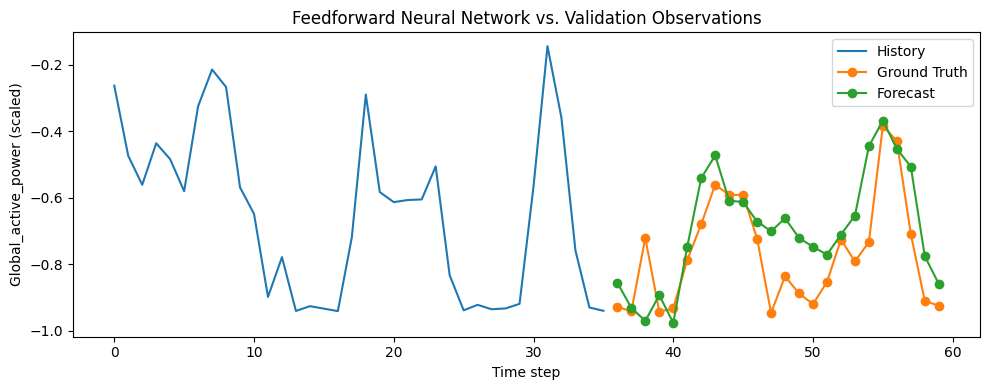

In [25]:
plot_forecast_sample(
    model=feedforward_model,
    dataset=val_dataset,
    config=SETUP_CONFIG,
    sample_index=0,
    target_index=used_target_index,
    title="Feedforward Neural Network vs. Validation Observations"
)

### 5.3 Compare Validation Metrics

In [26]:
import pandas as pd

def format_metric_dict(metric_dict):
    return {name: float(value) for name, value in metric_dict.items()}

comparison_df = pd.DataFrame(
    {
        "Naive Seasonal": format_metric_dict(baseline_metrics.get("val", {})),
        "Untrained FF NN": format_metric_dict(untrained_ff_metrics.get("val", {})),
        "Feedforward NN": format_metric_dict(ff_metrics.get("val", {})),
    }
).T

comparison_df

,loss,mae,rmse
Naive Seasonal,0.086434,0.203913,0.293996
Untrained FF NN,0.900994,0.799041,0.949207
Feedforward NN,0.047346,0.163200,0.217591


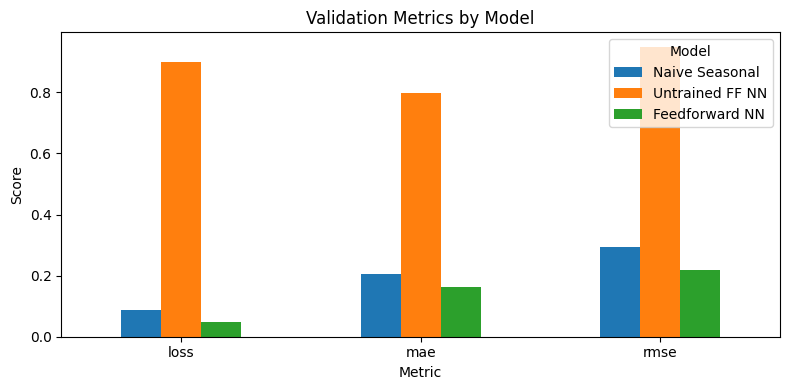

In [27]:
comparison_by_metric = comparison_df.T
ax = comparison_by_metric.plot(kind="bar", figsize=(8, 4))
ax.set_ylabel("Score")
ax.set_xlabel("Metric")
ax.set_title("Validation Metrics by Model")
ax.set_xticklabels(comparison_by_metric.index, rotation=0)
ax.legend(title="Model")
plt.tight_layout()
plt.show()

## 6. LSTM Encoder-Decoder

Recurrent encoder-decoder models process the input window step by step, compressing it into a latent state that summarizes the recent dynamics. The decoder then unfolds that state across the forecast horizon to predict future values. This architecture handles variable-length sequences gracefully and is a natural baseline before trying attention-based transformers.

Although the diagram shows only a couple of recurrent layers, the network is still **deep**: backpropagation through time unrolls each LSTM cell across every time step, creating a computational graph with dozens of effective layers. Gradients flow through this temporal depth, enabling the model to capture long-range dependencies that shallow feedforward stacks might miss.

In [28]:
class EncoderDecoderLSTM(keras.Model):
    """Simple encoder-decoder LSTM for multi-step forecasting."""
    def __init__(self, latent_dim, forecast_horizon, target_dim, dropout_rate=0.0):
        super().__init__()
        self.encoder = keras.layers.LSTM(
            latent_dim,
            return_state=True,
            name="encoder_lstm"
        )
        self.dropout = keras.layers.Dropout(dropout_rate, name="encoder_dropout") if dropout_rate > 0 else None
        # we repeat the context vector for each time step in the forecast horizon
        self.repeat = keras.layers.RepeatVector(forecast_horizon, name="repeat_context")
        self.decoder = keras.layers.LSTM(
            latent_dim,
            return_sequences=True,
            name="decoder_lstm"
        )
        self.projection = keras.layers.Dense(target_dim, name="forecast_dense") # it is automatically applied to each time step

    def call(self, inputs, training=False):
        encoder_output, state_h, state_c = self.encoder(inputs)
        if self.dropout is not None and training:
            encoder_output = self.dropout(encoder_output, training=training)
        repeated = self.repeat(encoder_output)

        # the decoder receives at each time step the result of the encoding repeated
        # and as initial state the final state of the encoder
        decoder_output = self.decoder(repeated, initial_state=[state_h, state_c])
        return self.projection(decoder_output)

In [29]:
LATENT_DIM = 128
TARGET_DIM = len(SETUP_CONFIG['target_columns'])
lstm_model = EncoderDecoderLSTM(
    latent_dim=LATENT_DIM,
    forecast_horizon=SETUP_CONFIG['forecast_horizon'],
    target_dim=TARGET_DIM,
    dropout_rate=0.1
)

lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.MeanSquaredError(),
    metrics=[
        keras.metrics.MeanAbsoluteError(name="mae"),
        keras.metrics.RootMeanSquaredError(name="rmse")
    ]
)

lstm_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True
    )
]

lstm_history = lstm_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2,  # TRAINING_CONFIG['epochs'],
    callbacks=lstm_callbacks,
    verbose=1
)

lstm_model.summary()

Epoch 1/2
755/755 ━━━━━━━━━━━━━━━━━━━━ 56s 73ms/step - loss: 0.0743 - mae: 0.2081 - rmse: 0.2707 - val_loss: 0.0468 - val_mae: 0.1595 - val_rmse: 0.2164
Epoch 2/2
755/755 ━━━━━━━━━━━━━━━━━━━━ 56s 73ms/step - loss: 0.0743 - mae: 0.2081 - rmse: 0.2707 - val_loss: 0.0468 - val_mae: 0.1595 - val_rmse: 0.2164
Epoch 2/2
755/755 ━━━━━━━━━━━━━━━━━━━━ 61s 81ms/step - loss: 0.0520 - mae: 0.1657 - rmse: 0.2279 - val_loss: 0.0461 - val_mae: 0.1601 - val_rmse: 0.2148
755/755 ━━━━━━━━━━━━━━━━━━━━ 61s 81ms/step - loss: 0.0520 - mae: 0.1657 - rmse: 0.2279 - val_loss: 0.0461 - val_mae: 0.1601 - val_rmse: 0.2148


Model: "encoder_decoder_lstm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_lstm (LSTM)             │ ((None, 128), (None,   │        75,776 │
│                                 │ 128), (None, 128))     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout (Dropout)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_context (RepeatVector)   │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm (LSTM)             │ (None, 24, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ forecast_dense (Dense)          │ (None, 24, 1)          │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 622,469 (2.37 MB)

 Trainable params: 207,489 (810.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 414,980 (1.58 MB)

In [30]:
lstm_metrics = {}
for split_name, dataset in split_datasets.items():
    lstm_metrics[split_name] = lstm_model.evaluate(dataset, verbose=0, return_dict=True)

### 6.1 LSTM Training Curves

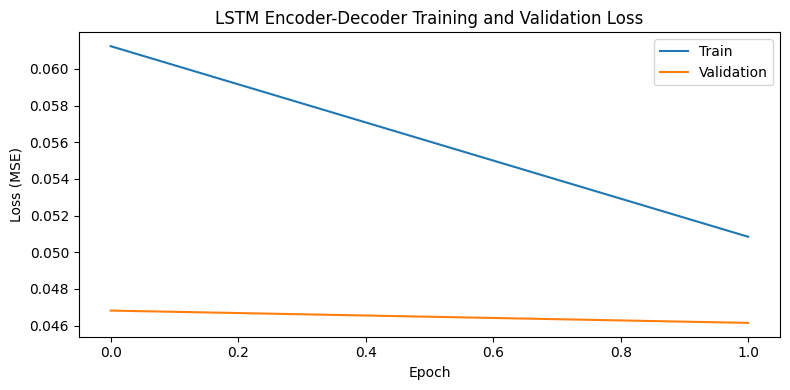

In [31]:
if lstm_history is None:
    raise ValueError("Run the LSTM training cell before plotting the learning curves.")

lstm_history_df = pd.DataFrame(lstm_history.history)
ax = lstm_history_df[["loss", "val_loss"]].plot(figsize=(8, 4))
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss (MSE)")
ax.set_title("LSTM Encoder-Decoder Training and Validation Loss")
ax.legend(["Train", "Validation"])
plt.tight_layout()
plt.show()

### 6.2 Forecast Sample on the Validation Set

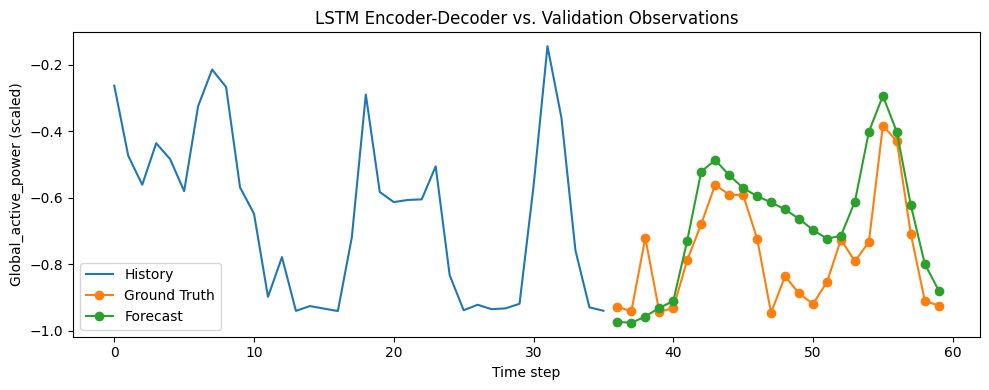

In [32]:
plot_forecast_sample(
    model=lstm_model,
    dataset=val_dataset,
    config=SETUP_CONFIG,
    sample_index=0,
    target_index=used_target_index,
    title="LSTM Encoder-Decoder vs. Validation Observations"
)

### 6.3 Alternate LSTM Encoder-Decoder Configuration

In [33]:
LATENT_DIM_ALT = 64
DROPOUT_ALT = 0.3
ALT_LEARNING_RATE = 5e-4

lstm_model_compact = EncoderDecoderLSTM(
    latent_dim=LATENT_DIM_ALT,
    forecast_horizon=SETUP_CONFIG['forecast_horizon'],
    target_dim=TARGET_DIM,
    dropout_rate=DROPOUT_ALT,
)

lstm_model_compact.compile(
    optimizer=keras.optimizers.Adam(learning_rate=ALT_LEARNING_RATE),
    loss=keras.losses.MeanSquaredError(),
    metrics=[
        keras.metrics.MeanAbsoluteError(name="mae"),
        keras.metrics.RootMeanSquaredError(name="rmse"),
    ],
)

lstm_callbacks_alt = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
    )
]

lstm_history_compact = lstm_model_compact.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2,  # Adjust upward when you have more time to train
    callbacks=lstm_callbacks_alt,
    verbose=1,
)

lstm_model_compact.summary()

Epoch 1/2


755/755 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.0884 - mae: 0.2306 - rmse: 0.2947 - val_loss: 0.0623 - val_mae: 0.2010 - val_rmse: 0.2495
Epoch 2/2
755/755 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - loss: 0.0884 - mae: 0.2306 - rmse: 0.2947 - val_loss: 0.0623 - val_mae: 0.2010 - val_rmse: 0.2495
Epoch 2/2
755/755 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - loss: 0.0632 - mae: 0.1912 - rmse: 0.2513 - val_loss: 0.0477 - val_mae: 0.1659 - val_rmse: 0.2184
755/755 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - loss: 0.0632 - mae: 0.1912 - rmse: 0.2513 - val_loss: 0.0477 - val_mae: 0.1659 - val_rmse: 0.2184


Model: "encoder_decoder_lstm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_lstm (LSTM)             │ ((None, 64), (None,    │        21,504 │
│                                 │ 64), (None, 64))       │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout (Dropout)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_context (RepeatVector)   │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm (LSTM)             │ (None, 24, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ forecast_dense (Dense)          │ (None, 24, 1)          │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 163,781 (639.77 KB)

 Trainable params: 54,593 (213.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 109,188 (426.52 KB)

In [34]:
lstm_compact_metrics = {}
for split_name, dataset in split_datasets.items():
    lstm_compact_metrics[split_name] = lstm_model_compact.evaluate(dataset, verbose=0, return_dict=True)

for split_name, values in lstm_compact_metrics.items():
    print(f"{split_name} metrics (compact LSTM):")
    for metric_name, value in values.items():
        print(f"  {metric_name}: {value:.4f}")

train metrics (compact LSTM):
  loss: 0.0519
  mae: 0.1666
  rmse: 0.2279
val metrics (compact LSTM):
  loss: 0.0477
  mae: 0.1659
  rmse: 0.2184
test metrics (compact LSTM):
  loss: 0.0340
  mae: 0.1354
  rmse: 0.1845


### 6.4 Compare Validation Metrics Including the LSTM

In [35]:
lstm_val_comparison_df = pd.DataFrame(
    {
        "Naive Seasonal": format_metric_dict(baseline_metrics.get("val", {})),
        "Feedforward NN": format_metric_dict(ff_metrics.get("val", {})),
        "LSTM Encoder-Decoder (128 units)": format_metric_dict(lstm_metrics.get("val", {})),
        "LSTM Encoder-Decoder (64 units)": format_metric_dict(lstm_compact_metrics.get("val", {})),
    }
).T

lstm_val_comparison_df

,loss,mae,rmse
Naive Seasonal,0.086434,0.203913,0.293996
Feedforward NN,0.047346,0.163200,0.217591
LSTM Encoder-Decoder (128 units),0.046144,0.160052,0.214812
LSTM Encoder-Decoder (64 units),0.047679,0.165883,0.218354


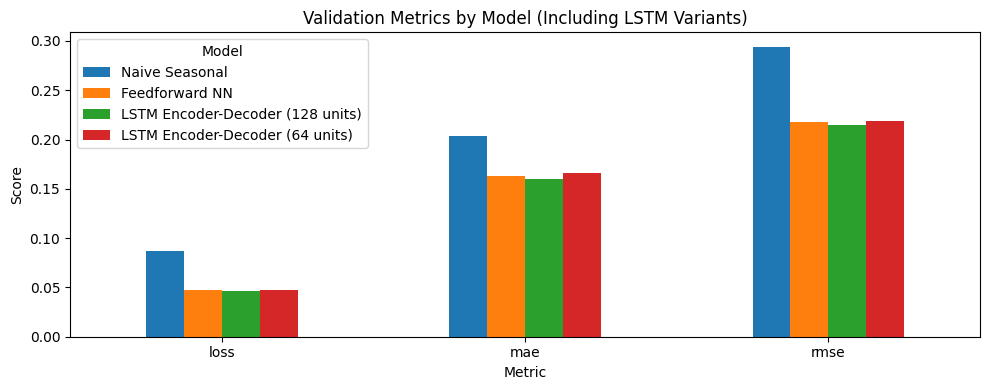

In [36]:
lstm_val_comparison_by_metric = lstm_val_comparison_df.T
ax = lstm_val_comparison_by_metric.plot(kind="bar", figsize=(10, 4))
ax.set_ylabel("Score")
ax.set_xlabel("Metric")
ax.set_title("Validation Metrics by Model (Including LSTM Variants)")
ax.set_xticklabels(lstm_val_comparison_by_metric.index, rotation=0)
ax.legend(title="Model")
plt.tight_layout()
plt.show()

💡 **Try It Yourself:** Experiment by tweaking the latent dimension, dropout, learning rate, or number of epochs in either LSTM block above. Re-run the training and comparison cells to see how the validation metrics shift and discuss what configurations work best.

### 6.5 Compare Test Metrics

With hyperparameters selected on the validation set, we can now benchmark the best-performing models on the held-out test split to estimate their real-world generalization.

In [37]:
test_comparison_df = pd.DataFrame(
    {
        "Naive Seasonal": format_metric_dict(baseline_metrics.get("test", {})),
        "Feedforward NN": format_metric_dict(ff_metrics.get("test", {})),
        "LSTM Encoder-Decoder (128 units)": format_metric_dict(lstm_metrics.get("test", {})),
    }
).T

test_comparison_df

,loss,mae,rmse
Naive Seasonal,0.053326,0.154933,0.230923
Feedforward NN,0.033418,0.135202,0.182806
LSTM Encoder-Decoder (128 units),0.032217,0.131772,0.179490


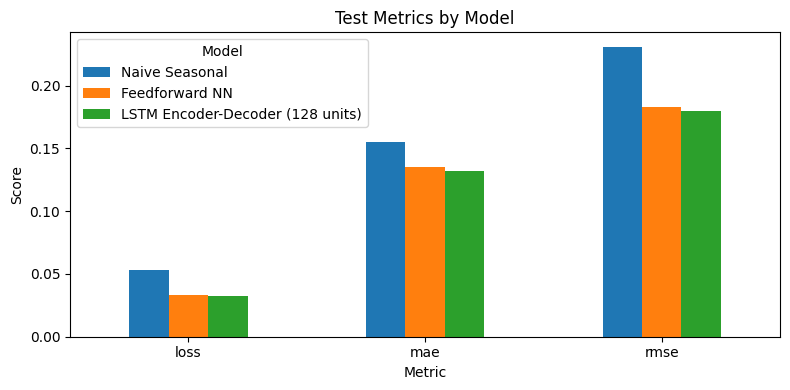

In [38]:
test_comparison_by_metric = test_comparison_df.T
ax = test_comparison_by_metric.plot(kind="bar", figsize=(8, 4))
ax.set_ylabel("Score")
ax.set_xlabel("Metric")
ax.set_title("Test Metrics by Model")
ax.set_xticklabels(test_comparison_by_metric.index, rotation=0)
ax.legend(title="Model")
plt.tight_layout()
plt.show()

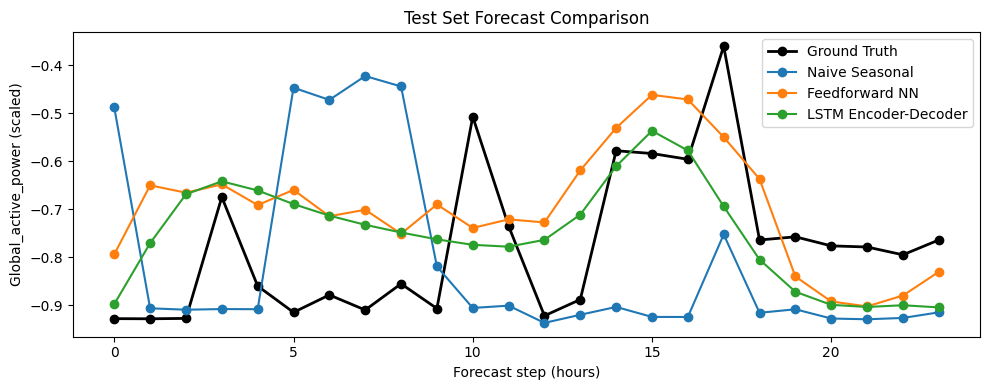

In [39]:
# Compare model predictions on a shared test sample
sample_index = 0
target_index = used_target_index
test_inputs, test_targets = next(iter(test_dataset))

# Collect ground truth and model predictions
ground_truth = test_targets.numpy()[sample_index, :, target_index]
forecast_steps = np.arange(SETUP_CONFIG['forecast_horizon'])
model_predictions = {}
for model_name, model in [
    ("Naive Seasonal", naive_seasonal_model),
    ("Feedforward NN", feedforward_model),
    ("LSTM Encoder-Decoder", lstm_model),
]:
    preds = model.predict(test_inputs, verbose=0)
    model_predictions[model_name] = preds[sample_index, :, target_index]

# Plot forecasts against the ground truth
plt.figure(figsize=(10, 4))
plt.plot(forecast_steps, ground_truth, label="Ground Truth", color="black", linewidth=2, marker="o")
for model_name, preds in model_predictions.items():
    plt.plot(forecast_steps, preds, label=model_name, marker="o")

plt.xlabel("Forecast step (hours)")
plt.ylabel("Global_active_power (scaled)")
plt.title("Test Set Forecast Comparison")
plt.legend()
plt.tight_layout()
plt.show()

## 7. Key Takeaways
- Naive seasonal baseline remains a strong starting point but quickly falls behind learned models on multi-step forecasts.
- Feedforward network captures short-term structure, improving MAE/RMSE over the baseline with modest complexity.
- LSTM encoder-decoder delivers the lowest errors by leveraging temporal memory, though it introduces more training cost.
- Visualizing the shared test batch confirms metric trends: LSTM aligns closest with ground truth, while the baseline lags when the pattern shifts.
- Future extensions: tune horizons and Fourier features, explore attention-based architectures, and evaluate probabilistic forecasts for risk-aware decisions.